### imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

# import logging
# logging.basicConfig(level=logging.DEBUG)
import sys 
sys.path.append('/Users/wzhang/Documents/work/e-mission-server')
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq

from performance_eval import get_clf_metrics, cv_for_all_algs, PREDICTORS

### load data

In [2]:
all_users = esta.TimeSeries.get_uuid_list()
confirmed_trip_df_map = {}
labeled_trip_df_map = {}
expanded_labeled_trip_df_map = {}
expanded_all_trip_df_map = {}
for u in all_users:
    ts = esta.TimeSeries.get_time_series(u)
    ct_df = ts.get_data_df("analysis/confirmed_trip")

    confirmed_trip_df_map[u] = ct_df
    labeled_trip_df_map[u] = esdtq.filter_labeled_trips(ct_df)
    expanded_labeled_trip_df_map[u] = esdtq.expand_userinputs(
        labeled_trip_df_map[u])
    expanded_all_trip_df_map[u] = esdtq.expand_userinputs(
        confirmed_trip_df_map[u])

In [3]:
print(expanded_labeled_trip_df_map[all_users[1]])

                          source        end_ts  \
0    DwellSegmentationDistFilter  1.626213e+09   
1    DwellSegmentationDistFilter  1.626228e+09   
2    DwellSegmentationDistFilter  1.626232e+09   
3    DwellSegmentationDistFilter  1.626298e+09   
4    DwellSegmentationDistFilter  1.626310e+09   
..                           ...           ...   
233  DwellSegmentationDistFilter  1.632721e+09   
234  DwellSegmentationDistFilter  1.632792e+09   
235  DwellSegmentationDistFilter  1.632823e+09   
236  DwellSegmentationDistFilter  1.632823e+09   
237  DwellSegmentationDistFilter  1.632823e+09   

                         end_fmt_time  \
0    2021-07-13T15:45:20.999802-06:00   
1    2021-07-13T19:58:46.999936-06:00   
2    2021-07-13T21:05:57.999985-06:00   
3    2021-07-14T15:32:48.000641-06:00   
4    2021-07-14T18:46:31.999891-06:00   
..                                ...   
233  2021-09-26T23:42:51.999974-06:00   
234  2021-09-27T19:15:18.023835-06:00   
235  2021-09-28T03:58:24.00022

check how many labeled/unlabeled trips there are:

In [4]:
n_trips_df = pd.DataFrame(
    [[u, len(confirmed_trip_df_map[u]),
      len(labeled_trip_df_map[u])] for u in all_users],
    columns=["user_id", "all_trips", "labeled_trips"])

all_trips = n_trips_df.all_trips.sum()
labeled_trips = n_trips_df.labeled_trips.sum()
unlabeled_trips = all_trips - labeled_trips
n_users = len(n_trips_df)

print('{} ({:.2f}%) unlabeled, {} ({:.2f}%) labeled, {} total trips'.format(
    unlabeled_trips, unlabeled_trips / all_trips, labeled_trips,
    labeled_trips / all_trips, all_trips))

n_users_too_few_trips = len(n_trips_df[n_trips_df.labeled_trips < 5])
print(
    '{}/{} ({:.2f}%) users have less than 5 labeled trips and cannot do cross-validation'
    .format(n_users_too_few_trips, n_users, n_users_too_few_trips / n_users))

trips_for_crossval = n_trips_df[
    n_trips_df.labeled_trips >= 5].labeled_trips.sum()
print('{} trips usable for 5-fold cross-validation from {}/{} ({:.2f}%) users'.
      format(trips_for_crossval, n_users - n_users_too_few_trips, n_users,
             (n_users - n_users_too_few_trips) / n_users))


9149 (0.63%) unlabeled, 5268 (0.37%) labeled, 14417 total trips
2/16 (0.12%) users have less than 5 labeled trips and cannot do cross-validation
5268 trips usable for 5-fold cross-validation from 14/16 (0.88%) users


### evaluate performance in aggregate

The following cell will load the cross-validation results for the listed models. (Parameters for the models being tested can be found in tour_model_eval/performance_eval.py)

If the cross-validation results for a model have already been generated, it will attempt to load it from the csv file to avoid the time-consuming process of re-running it. Otherwise, it will run the cross-validation from scratch. (This feature can be toggled with the override_prior_runs parameter - if True, it will ignore existing csv's and re-run from scratch.)

WARNING! The following cell will take *insanely long* to run - as in, potentially up to 2 days - largely due to the fixed-width clustering algorithms. If you don't care about those, I suggest removing them from the list of models to evaluate. The other models took me ~20min each to run.

In [5]:
model_names = list(PREDICTORS.keys())
cv_results = cv_for_all_algs(
    uuid_list=all_users,
    expanded_trip_df_map=expanded_labeled_trip_df_map,
    model_names=model_names,
    override_prior_runs=False,
    raise_errors=False,
    random_state=42,
)

loading prior cross validation data for model: random forests (coordinates)


In [6]:
df1 = pd.DataFrame(cv_results['random forests (coordinates)'])
validation_trips = df1[df1['dataset'] == 'validation_dataset']
test_trips = df1[df1['dataset'] != 'validation_dataset']

In [15]:
# import uuid

# target_uuid = uuid.UUID('e9e479e9-5c3f-4345-a885-dadb7999b312')
# user = df1[df1['user_id'] ==target_uuid]
# df1['user_id'].unique()

In [15]:
# store results for all models in a nice dataframe

mode_results = {}

for model_name in cv_results.keys():
    print(f'now geting: {model_name}')
    for label_type in ['purpose', 'mode', 'replaced']:
        # get results
        results = get_clf_metrics(test_trips,
                                  label_type,
                                  keep_nopred=True,
                                  ignore_custom=False)

        if label_type == "mode":
            mode_results["%s_pred" % model_name] = results['label_pred']
            mode_results["%s_true" % model_name] = results['label_true']
            mode_results["%s_user_id" % model_name] = results['user_id']


now geting: random forests (coordinates)


In [ ]:
# store results for all models in a nice dataframe
all_model_results = {
    ('model_name', ''): [],
    ('trips without prediction', 'purpose'): [],
    ('trips without prediction', 'mode'): [],
    ('trips without prediction', 'replaced'): [],
    ('accuracy overall', 'purpose'): [],
    ('accuracy overall', 'mode'): [],
    ('accuracy overall', 'replaced'): [],
    ('accuracy of trips w predictions', 'purpose'): [],
    ('accuracy of trips w predictions', 'mode'): [],
    ('accuracy of trips w predictions', 'replaced'): [],
    ('f1 weighted', 'purpose'): [],
    ('f1 weighted', 'mode'): [],
    ('f1 weighted', 'replaced'): [],
}

purpose_results = {}
mode_results = {}

for model_name in cv_results.keys():
    print(f'now evaluating: {model_name}')
    all_model_results[('model_name', '')] += [model_name]
    for label_type in ['purpose', 'mode', 'replaced']:
        # get results
        results = get_clf_metrics(cv_results[model_name],
                                  label_type,
                                  keep_nopred=True,
                                  ignore_custom=False)

        if label_type == "purpose":
            purpose_results["%s_pred" % model_name] = results['label_pred']
            purpose_results["%s_true" % model_name] = results['label_true']

        if label_type == "mode":
            mode_results["%s_pred" % model_name] = results['label_pred']
            mode_results["%s_true" % model_name] = results['label_true']
            mode_results["%s_user_id" % model_name] = results['user_id']

        # update our dict of aggregate results
        all_model_results[('trips without prediction', label_type)] += [
            results['n_trips_without_prediction']
        ]
        all_model_results[('accuracy overall',
                           label_type)] += [results['accuracy']]
        all_model_results[('accuracy of trips w predictions', label_type)] += [
            results['accuracy'] * len(results['label_true']) /
            (len(results['label_true']) -
             results['n_trips_without_prediction'])
        ]
        all_model_results[('f1 weighted',
                           label_type)] += [results['weighted_f_score']]

all_model_results_df = pd.DataFrame(all_model_results)
all_model_results_df.to_csv('all_model_results.csv')

In [11]:
purpose_results_df = pd.concat(purpose_results, axis=1, join='outer')
purpose_results_df.to_csv("compare_true_pred_models.csv")

In [ ]:
purpose_results_df[['fixed-width (O-D)_pred', 'fixed-width (O-D)_true', 'fixed-width (O-D, destination)_pred', 'fixed-width (O-D, destination)_true']].head(n=20)

In [ ]:
purpose_results_df[['fixed-width (O-D)_pred', 'fixed-width (O-D)_true', 'fixed-width (O-D, destination)_pred', 'fixed-width (O-D, destination)_true']].loc[:2000].sample(n=20)

Get mode_results confusion matrix

In [13]:
mode_results_df = pd.concat(mode_results, axis=1, join='outer')
mode_results_df.to_csv("compare_true_pred_mode_models.csv")

In [14]:
mode_df = pd.DataFrame(pd.read_csv("compare_true_pred_mode_models.csv"))
mode_df = mode_df.drop(['Unnamed: 0'], axis=1)
mode_df

,random forests (coordinates)_pred,random forests (coordinates)_true,random forests (coordinates)_user_id
0,taxi,pilot_ebike,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
1,pilot_ebike,pilot_ebike,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
2,taxi,taxi,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
3,pilot_ebike,walk,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
4,pilot_ebike,pilot_ebike,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
...,...,...,...
5239,drove_alone,drove_alone,e9e479e9-5c3f-4345-a885-dadb7999b312
5240,drove_alone,drove_alone,e9e479e9-5c3f-4345-a885-dadb7999b312
5241,drove_alone,drove_alone,e9e479e9-5c3f-4345-a885-dadb7999b312
5242,pilot_ebike,pilot_ebike,e9e479e9-5c3f-4345-a885-dadb7999b312


In [147]:
mode_df = mode_df.rename(columns={"random forests (coordinates)_pred": "predicted_value", "random forests (coordinates)_true": "true_value", "random forests (coordinates)_user_id": "user_id"})
mode_df

,predicted_value,true_value,user_id
0,taxi,pilot_ebike,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
1,pilot_ebike,pilot_ebike,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
2,taxi,taxi,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
3,pilot_ebike,walk,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
4,pilot_ebike,pilot_ebike,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
...,...,...,...
5239,drove_alone,drove_alone,e9e479e9-5c3f-4345-a885-dadb7999b312
5240,drove_alone,drove_alone,e9e479e9-5c3f-4345-a885-dadb7999b312
5241,drove_alone,drove_alone,e9e479e9-5c3f-4345-a885-dadb7999b312
5242,pilot_ebike,pilot_ebike,e9e479e9-5c3f-4345-a885-dadb7999b312


In [ ]:
confusion_matrices = mode_df.groupby('user_id')
user_confusion_matrices_dic = {}
for user, confusion_matrix in confusion_matrices.items():
    user_confusion_matrices_dic[user] = confusion_matrix
    print(user)
    
first_user_id = list(user_confusion_matrices_dic.keys())[0]
first_confusion_matrix = list(user_confusion_matrices_dic.values())[0]


In [156]:
# Set the display options to show more rows and columns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

user_confusion_matrices_dic = {}

grouped_user = mode_df.groupby('user_id')
for user_id, group_df in grouped_user:
    predicted_values = group_df['predicted_value']
    true_values = group_df['true_value']
    confusion_matrix = pd.crosstab(true_values, predicted_values)
    
    user_confusion_matrices_dic[user_id] = confusion_matrix

for user_id, confusion_matrix in user_confusion_matrices_dic.items():
    print("User ID:", user_id)
    print("Confusion Matrix:")
    print(confusion_matrix)
    print()
    # break


2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
509b9093-9093-4e98-8eb1-20b58ed9bd8c
56e23e21-6152-4f59-9253-50bd28a5d7f9
5ad862e7-9a63-41f6-9f28-c0096fe884da
6656c04c-6cba-4c18-9fed-805eaa529741
840297ae-3948-4e26-bfeb-e83ee30c5b3e
863e9c6c-8ec0-48c4-b765-3f73d839c85b
9910245f-ee4e-4cca-ab4c-dd2312eb0d5d
c6807997-194c-4c52-8a8f-a8c1f6ee1595
c6e4db31-c18b-4355-b02a-7dd97deca70b
d7a732f4-a864-4bcb-b8de-dfc8be242fb2
e192b8a0-0b6c-4222-9685-1c93785deaf7
e4cfb2a8-f600-4268-9756-9985e234636e
e9e479e9-5c3f-4345-a885-dadb7999b312
User ID: 2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d
Confusion Matrix:
predicted_value  drove_alone  not_a_trip  pilot_ebike  shared_ride  taxi  walk
true_value                                                                    
drove_alone               14           0            3            1     2     2
not_a_trip                 0           0            3            0     0     0
pilot_ebike                0           1           37            2     1    14
shared_ride            

In [121]:
confusion_matrices

drove_alone  not_a_trip  \
user_id                              actual_value                            
2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d drove_alone          14.0         0.0   
                                     not_a_trip            0.0         0.0   
                                     pilot_ebike           0.0         1.0   
                                     shared_ride           5.0         0.0   
                                     taxi                  1.0         0.0   
...                                                        ...         ...   
e4cfb2a8-f600-4268-9756-9985e234636e shared_ride           NaN         NaN   
e9e479e9-5c3f-4345-a885-dadb7999b312 drove_alone         155.0         NaN   
                                     not_a_trip            1.0         NaN   
                                     pilot_ebike           6.0         NaN   
                                     walk                  5.0         NaN   

                                                   pilot_ebike  shared_ride  \
user_id                              actual_value                             
2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d drove_alone           3.0          1.0   
                                     not_a_trip            3.0          0.0   
                                     pilot_ebike          37.0          2.0   
                                     shared_ride           2.0          4.0   
                                     taxi                  0.0          0.0   
...                                                        ...          ...   
e4cfb2a8-f600-4268-9756-9985e234636e shared_ride           3.0          NaN   
e9e479e9-5c3f-4345-a885-dadb7999b312 drove_alone           0.0          NaN   
                                     not_a_trip            0.0          NaN   
                                     pilot_ebike           7.0          NaN   
                                     walk                  0.0          NaN   

                                                   taxi  walk  bus  bike  air  \
user_id                              actual_value                               
2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d drove_alone    2.0   2.0  NaN   NaN  NaN   
                                     not_a_trip     0.0   0.0  NaN   NaN  NaN   
                                     pilot_ebike    1.0  14.0  NaN   NaN  NaN   
                                     shared_ride    1.0   3.0  NaN   NaN  NaN   
                                     taxi           5.0   1.0  NaN   NaN  NaN   
...                                                 ...   ...  ...   ...  ...   
e4cfb2a8-f600-4268-9756-9985e234636e shared_ride    NaN   NaN  NaN   NaN  NaN   
e9e479e9-5c3f-4345-a885-dadb7999b312 drove_alone    NaN   NaN  NaN   NaN  NaN   
                                     not_a_trip     NaN   NaN  NaN   NaN  NaN   
                                     pilot_ebike    NaN   NaN  NaN   NaN  NaN   
                                     walk           NaN   NaN  NaN   NaN  NaN   

                                                   boat  canoe  \
user_id                              actual_value                
2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d drove_alone    NaN    NaN   
                                     not_a_trip     NaN    NaN   
                                     pilot_ebike    NaN    NaN   
                                     shared_ride    NaN    NaN   
                                     taxi           NaN    NaN   
...                                                 ...    ...   
e4cfb2a8-f600-4268-9756-9985e234636e shared_ride    NaN    NaN   
e9e479e9-5c3f-4345-a885-dadb7999b312 drove_alone    NaN    NaN   
                                     not_a_trip     NaN    NaN   
                                     pilot_ebike    NaN    NaN   
                                     walk           NaN    NaN   

                                                   canoe,_with others  ferry  \
user_id        

In [125]:
pd.crosstab(mode_df['actual_value'], mode_df['prediction'])

prediction,air,bike,bikeshare,boat,boats,bus,canoe,"canoe,_with others",drove_alone,ferry,jeep,kayak,not_a_trip,pilot_ebike,shared_ride,skateboard,taxi,walk
actual_value,,,,,,,,,,,,,,,,,,
air,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
bike,0,10,4,0,0,2,0,0,9,0,0,0,1,9,11,0,0,1
bikeshare,0,1,18,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1
boat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
boats,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
bus,0,1,0,0,0,21,0,0,0,0,0,0,0,4,5,0,0,0
canoe,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0
"canoe,_with others",0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
drove_alone,0,1,0,0,0,0,0,0,537,0,0,1,5,94,99,4,2,8


In [101]:
pred_mode_list = mode_df['random forests (coordinates)_pred'].unique().tolist()
true_mode_list = mode_df['random forests (coordinates)_true'].unique().tolist()

In [103]:
len(pred_mode_list)

18

In [73]:
confusion_matrix = pd.crosstab(mode_df['random forests (coordinates)_true'], mode_df['random forests (coordinates)_pred'])
confusion_matrix

random forests (coordinates)_pred,air,bike,bikeshare,boat,boats,bus,canoe,"canoe,_with others",drove_alone,ferry,jeep,kayak,not_a_trip,pilot_ebike,shared_ride,skateboard,taxi,walk
random forests (coordinates)_true,,,,,,,,,,,,,,,,,,
air,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
bike,0,10,4,0,0,2,0,0,9,0,0,0,1,9,11,0,0,1
bikeshare,0,1,18,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1
boat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
boats,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
bus,0,1,0,0,0,21,0,0,0,0,0,0,0,4,5,0,0,0
canoe,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0
"canoe,_with others",0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
drove_alone,0,1,0,0,0,0,0,0,537,0,0,1,5,94,99,4,2,8


Q: Which modes to choose?
Q: the real energy intensity of the mode?

In [61]:
from sklearn.metrics import confusion_matrix

predicted = mode_df['random forests (coordinates)_pred']
true = mode_df['random forests (coordinates)_true']

cm = confusion_matrix(true, predicted)
cm_df = pd.DataFrame(cm)
cm_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
1,0,10,4,0,0,2,0,0,9,0,0,0,0,1,0,9,11,0,0,1
2,0,1,18,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,21,0,0,0,0,0,0,0,0,0,4,5,0,0,0
6,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,537,0,0,0,1,5,0,94,99,4,2,8
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0


In [47]:
pd.read_csv("/Users/wzhang/Documents/work/e-mission-eval-private-data/TRB_label_assist/first_trial_results/cv results random forests (coordinates).csv").head()

,Unnamed: 0,idx,mode_true,purpose_true,replaced_true,mode_pred,purpose_pred,replaced_pred,distance,user_id,top_pred
0,0,9.0,pilot_ebike,entertainment,taxi,taxi,shopping,walk,34204.087046,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,True
1,1,12.0,pilot_ebike,work,taxi,pilot_ebike,work,taxi,3529.718059,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,True
2,2,15.0,taxi,transit_transfer,drove_alone,taxi,shopping,drove_alone,44180.480159,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,True
3,3,18.0,walk,shopping,shared_ride,pilot_ebike,shopping,drove_alone,1927.836205,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,True
4,4,19.0,pilot_ebike,work,drove_alone,pilot_ebike,work,drove_alone,3314.393622,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,True


In [14]:
all_model_results_df.sort_values(by=[('accuracy overall', 'purpose')], axis=0)

model_name trips without prediction                \
                                                 purpose mode replaced   
0  random forests (coordinates)                        0    0        0   

  accuracy overall                     accuracy of trips w predictions  \
           purpose      mode  replaced                         purpose   
0         0.704559  0.796911  0.802196                        0.704559   

                      f1 weighted                     
       mode  replaced     purpose     mode  replaced  
0  0.796911  0.802196    0.695814  0.78968  0.799702

In [15]:
# dropping the fixed-width (O-D, destination) results since they are significantly worse than the others
# and we don't have the time to figure out why
all_model_results_df = all_model_results_df[all_model_results_df['model_name'] != 'fixed-width (O-D, destination)']
all_model_results_df.to_csv('all_model_results.csv')

### visualize performance (bar graphs)

(code copied from tour_model_eval/eval_comparison_plots.ipynb)

#### prep the dataframe

In [16]:
multi_index = pd.MultiIndex.from_product([[
    "trips without prediction", "accuracy overall",
    "accuracy of trips with predictions", "f1 weighted"
], ["mode", "purpose", "replaced"]])

all_eval_results = pd.read_csv("all_model_results.csv",
                               header=[0,
                                       1]).drop(columns=["Unnamed: 0_level_0"])

all_eval_results.set_index("model_name", inplace=True)
all_eval_results.head()
all_eval_results = all_eval_results.transpose().reset_index()
all_eval_results.rename(columns={
    "level_0": "metric",
    "level_1": "label_type"
},
                        inplace=True)


def remove_brackets(cn):
    if type(cn) == tuple:
        return cn[0]
    else:
        return cn


all_eval_results = all_eval_results.rename(
    mapper=lambda cn: remove_brackets(cn), axis=1)

all_eval_results.set_index("label_type", inplace=True)

all_eval_results = all_eval_results[
    all_eval_results.metric != "trips without prediction"]
all_eval_results = all_eval_results[
    all_eval_results.metric != "accuracy of trips w predictions"]


/Users/wzhang/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


#### plot

plotting accuracy overall at location 0
plotting f1 weighted at location 1


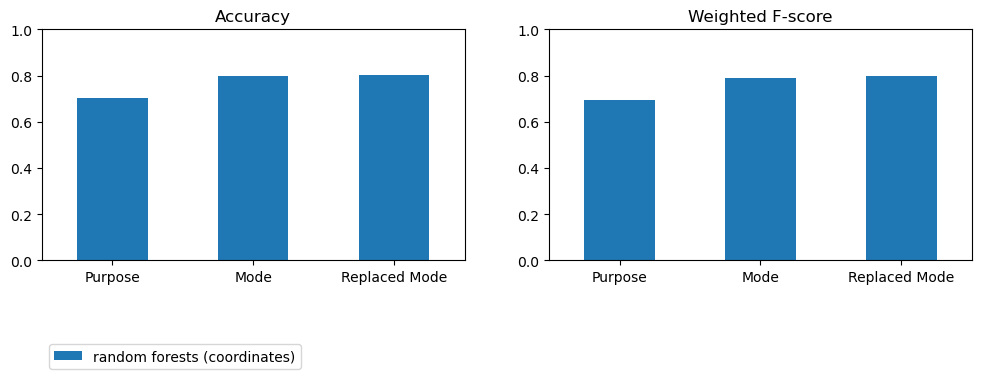

In [17]:
plt.style.use('default')
fig, ax_arr = plt.subplots(nrows=1,
                           ncols=2,
                           sharex=True,
                           sharey=False,
                           figsize=(12, 3))
ax_list = ax_arr
titles = ['Accuracy', 'Weighted F-score']
labels = ['Purpose', 'Mode', 'Replaced Mode']

for i, (metric, result_df) in enumerate(
        all_eval_results[all_eval_results.metric != "trips without prediction"]
        .groupby("metric")):
    print(f"plotting {metric} at location {i}")
    result_df.plot(kind="bar",
                   ax=ax_list[i],
                   title=titles[i],
                   legend=False,
                   ylim=(0, 1))
    plt.draw()
    ax_list[i].set_xticklabels(labels, rotation=0)
ax_list[0].legend(loc="lower left", bbox_to_anchor=(0.0, -0.5), ncol=3)

ax_list[0].set_xlabel('')
ax_list[1].set_xlabel('')

# plt.tight_layout()
plt.show()

### evaluate performance of different models against the size of each user's dataset

evaluate each algorithm's purpose prediction accuracy against the number of trips per user

In [ ]:
results_by_user = []

results_by_user = {
    ('', 'user_id'): [],
    ('', 'num_labeled_trips'): [],
}
# populate the dictionary
for model_name in model_names:
    results_by_user[('accuracy', model_name)] = []
for model_name in model_names:
    results_by_user[('f1 weighted', model_name)] = []

for user in all_users:
    results_by_user[('', 'user_id')] += [user]
    results_by_user[('', 'num_labeled_trips')] += [
        len(expanded_labeled_trip_df_map[user])
    ]

    for model_name in model_names:
        cv_for_model = cv_results[model_name]

        if isinstance(cv_for_model.user_id.unique()[0], UUID):
            pass
        else:
            user = str(user)

        if user in cv_for_model.user_id.unique() and not all(
                cv_for_model.loc[cv_for_model.user_id == user,
                                 'purpose_pred'].isna()):
            results = get_clf_metrics(
                cv_for_model.loc[cv_for_model.user_id == user],
                label_type='purpose',
                keep_nopred=True,
                ignore_custom=False)

            results_by_user[('accuracy', model_name)] += [results['accuracy']]
            results_by_user[('f1 weighted',
                             model_name)] += [results['weighted_f_score']]
        else:
            results_by_user[('accuracy', model_name)] += [np.nan]
            results_by_user[('f1 weighted', model_name)] += [np.nan]

size_performance_df = pd.DataFrame(results_by_user)
size_performance_df.to_csv("dataset size vs performance for all algs.csv")
size_performance_df

In [ ]:
plt.style.use('default')

model_names = [
    'DBSCAN+SVM (O-D, destination)',
    'random forests (O-D, destination clusters)',
    'random forests (coordinates)'
]

fig, axs = plt.subplots(1, 2, figsize=(11, 4), sharex=True)
for i in range(len(model_names)):
    model_name = model_names[i]
    print(model_name)
    axs[0].scatter(
        size_performance_df[('', 'num_labeled_trips')],
        size_performance_df[('accuracy', model_name)],
        s=10,
        label=model_names[i])
    axs[1].scatter(
        size_performance_df[('', 'num_labeled_trips')],
        size_performance_df[('f1 weighted', model_name)],
        s=10,
        label=model_names[i])
axs[0].set_ylabel('Accuracy for Purpose')
axs[1].set_ylabel('Weighted F-score for Purpose')
axs[0].set_ylim(-0.1, 1.1)
axs[1].set_ylim(-0.1, 1.1)

axs[0].set_xlabel('Number of Labeled Trips')
axs[1].set_xlabel('Number of Labeled Trips')

# fig.suptitle(
#     'Comparison of Purpose Prediction Performance Against User Dataset Size')
axs[0].legend(loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3)
# plt.tight_layout()
plt.show()

In [ ]:
import scipy as scipy

In [ ]:
def func(x, a, b, c):
    return a * np.log(b * x) + c

In [ ]:
model_names = [
    'DBSCAN+SVM (O-D, destination)',
    'random forests (O-D, destination clusters)',
    'random forests (coordinates)'
]

size_performance_curve_fit = size_performance_df.dropna().sort_values(by=('', 'num_labeled_trips'))
fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharex=True, sharey=True)
for i in range(len(model_names)):
    model_name = model_names[i]
    print(model_name)
    xdata = size_performance_curve_fit[('', 'num_labeled_trips')]
    ydata = size_performance_curve_fit[('f1 weighted', model_name)]
    print("xdata has the following nan %s" % np.nonzero(np.isnan(xdata).to_numpy()))
    print("ydata has the following nan %s" % np.nonzero(np.isnan(ydata).to_numpy()))
    popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    print("After curve fitting, parameters are %s" % popt)
    axs[i].scatter(xdata, ydata, s=10)
    axs[i].plot(xdata, func(xdata, *popt), "r-")
    axs[i].set_xlabel('Number of Labeled Trips')
    axs[i].set_title(model_names[i])

axs[0].set_ylabel('Weighted F-score for Purpose')
axs[0].set_ylim(-0.1, 1.1)

# fig.suptitle(
#     'Comparison of Purpose Prediction Performance Against User Dataset Size')
# plt.tight_layout()
plt.show()    

In [ ]:
model_names = [
    'DBSCAN+SVM (O-D, destination)',
    'random forests (O-D, destination clusters)',
    'random forests (coordinates)'
]

size_performance_curve_fit = size_performance_df.dropna().sort_values(by=('', 'num_labeled_trips'))
fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
for i in range(len(model_names)):
    model_name = model_names[i]
    print(model_name)
    xdata = size_performance_curve_fit[('', 'num_labeled_trips')]
    ydata = size_performance_curve_fit[('f1 weighted', model_name)]
    print("xdata has the following nan %s" % np.nonzero(np.isnan(xdata).to_numpy()))
    print("ydata has the following nan %s" % np.nonzero(np.isnan(ydata).to_numpy()))
    popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    # kneedle = kneed.KneeLocator(xdata, ydata, S=1.0, curve="concave", direction="increasing")
    # print(kneedle.knee, kneedle.knee_y)
    print("After curve fitting, parameters are %s" % popt)
    axs.scatter(xdata, ydata, s=10, label=model_names[i])
    axs.plot(xdata, func(xdata, *popt), label=("%0.3f ln (%0.3f x) + %0.3f" % tuple(popt)))
    # x_knees = [125, 375]
    # y_knees = func(np.array([x_knees]), *popt)
    # axs.vlines(x_knees, -0.1, y_knees, linestyles="dashed")

axs.set_xlabel('Number of Labeled Trips')
axs.set_ylabel('Weighted F-score for Purpose')
axs.set_ylim(-0.1, 1.1)
# axs.set_xticks(list(axs.get_xticks()) + x_knees)

axs.legend()
# fig.suptitle(
#     'Comparison of Purpose Prediction Performance Against User Dataset Size')
# plt.tight_layout()
plt.show()    